## 1. Import libraries

In [2]:
import re
import math
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve
)
from lightgbm import LGBMClassifier

## 2. Functions

In [3]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test


def add_discount_features(
    df: pd.DataFrame,
    price_col: str = "price",
    original_price_col: str = "original_price",
    inplace: bool = True,
    keys_first: list[str] = ["id"],
) -> pd.DataFrame:
    """
    Crea:
      - has_discount (bool)
      - discount_pct (float, NaN si no aplica)
    Reordena: claves al inicio (si existen) y 'condition' al FINAL (solo si existe).
    """
    out = df if inplace else df.copy()

    # Features de descuento (solo si ambas columnas existen)
    if {price_col, original_price_col}.issubset(out.columns):
        out[price_col] = pd.to_numeric(out[price_col], errors="coerce")
        out[original_price_col] = pd.to_numeric(out[original_price_col], errors="coerce")

        out["has_discount"] = out[original_price_col].notna()
        out["discount_pct"] = np.where(
            out[original_price_col].notna() & (out[original_price_col] > 0),
            (out[original_price_col] - out[price_col]) / out[original_price_col],
            np.nan,
        )

    # ---------- Reordenamiento  ----------
    if "condition" in out.columns:
        out['condition2'] = out['condition']
        out.drop(columns=["condition"], inplace=True)
        out.rename(columns={"condition2": "condition"}, inplace=True)    # ----------------------------------------------------------------------

    return out


def build_items_dataframe(
    data: list,
    top_attributes: int = 15,
    expand_pictures: bool = True,
    expand_descriptions: bool = True,
    expand_payment_methods: bool = True,
    expand_attributes: bool = True,
) -> pd.DataFrame:
    if not data:
        return pd.DataFrame()

    # 1) Base aplanada
    base = json_normalize(data)

    # 2) Columnas clave a conservar
    keep = [
        'id', 'condition', 'title', 'price', 'original_price', 'currency_id',
        'category_id', 'site_id', 'listing_type_id', 'buying_mode', 'status',
        'sold_quantity', 'available_quantity', 'initial_quantity',
        'date_created', 'last_updated', 'stop_time', 'start_time',
        'accepts_mercadopago',
        'seller_address.country.id', 'seller_address.state.id',
        'seller_address.city.name', 'seller_address.latitude', 'seller_address.longitude',
        'shipping.mode', 'shipping.local_pick_up', 'shipping.free_shipping'
    ]
    keep = [c for c in keep if c in base.columns]
    df = base[keep].copy()

    # Alinear tipos de ID
    if 'id' in df.columns:
        df['id'] = df['id'].astype(str)

    # Renombres
    ren = {
        'seller_address.country.id': 'seller_country',
        'seller_address.state.id': 'seller_state',
        'seller_address.city.name': 'seller_city',
        'seller_address.latitude': 'seller_lat',
        'seller_address.longitude': 'seller_lon',
        'shipping.mode': 'shipping_mode',
        'shipping.local_pick_up': 'shipping_local_pick_up',
        'shipping.free_shipping': 'shipping_free_shipping',
    }
    df = df.rename(columns=ren)

    # 3) Fechas y features temporales
    for c in ['date_created', 'last_updated', 'stop_time', 'start_time']:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')

    if {'date_created', 'last_updated'}.issubset(df.columns):
        df['age_days'] = (df['last_updated'] - df['date_created']).dt.total_seconds() / 86400

    # 4) Texto del título
    if 'title' in df.columns:
        df['title'] = df['title'].fillna('')
        df['title_len'] = df['title'].str.len()
        df['title_has_new']  = df['title'].str.contains(r'\b(?:nuevo|nueva|new)\b', case=False, regex=True)
        df['title_has_used'] = df['title'].str.contains(r'\b(?:usado|used)\b', case=False, regex=True)

    # 5) Precio y proporciones
    if 'price' in df.columns:
        df['price_log'] = (df['price'].fillna(0) + 1).apply(math.log)

    if {'sold_quantity', 'available_quantity'}.issubset(df.columns):
        sold = df['sold_quantity'].fillna(0)
        avail = df['available_quantity'].fillna(0)
        denom = (sold + avail).replace(0, 1)
        df['sold_ratio'] = sold / denom

    # 6) PICTURES (robusto)
    if expand_pictures:
        pics_rows = []
        for item in data:
            item_id = str(item.get('id'))
            for p in (item.get('pictures') or []):
                if isinstance(p, dict):
                    row = {'id': item_id}
                    row.update(p)
                    pics_rows.append(row)

        if pics_rows:
            pics = pd.DataFrame(pics_rows)
            pics_agg = pics.groupby('id').size().rename('n_pictures').to_frame()

            if 'max_size' in pics.columns:
                def parse_px(s):
                    try:
                        w, h = map(int, str(s).lower().split('x'))
                        return w * h
                    except Exception:
                        return np.nan
                pics['max_px'] = pics['max_size'].apply(parse_px)
                px_agg = pics.groupby('id')['max_px'].max().rename('max_picture_px')
                pics_agg = pics_agg.join(px_agg, how='left')

            if 'secure_url' in pics.columns:
                has_secure = pics.groupby('id')['secure_url'].apply(lambda s: s.notna().any()).rename('has_secure_picture')
                pics_agg = pics_agg.join(has_secure, how='left')

            df = df.merge(pics_agg, on='id', how='left')

    for c, fill in [('n_pictures', 0), ('max_picture_px', 0), ('has_secure_picture', False)]:
        if c not in df.columns:
            df[c] = fill
        else:
            df[c] = df[c].fillna(fill)

    # 7) DESCRIPTIONS → conteo
    if expand_descriptions:
        desc_rows = []
        for item in data:
            item_id = str(item.get('id'))
            for _ in (item.get('descriptions') or []):
                desc_rows.append({'id': item_id})
        if desc_rows:
            desc = pd.DataFrame(desc_rows)
            desc_agg = desc.groupby('id').size().rename('n_descriptions').to_frame()
            df = df.merge(desc_agg, on='id', how='left')

    if 'n_descriptions' not in df.columns:
        df['n_descriptions'] = 0
    else:
        df['n_descriptions'] = df['n_descriptions'].fillna(0)

    # 8) MÉTODOS DE PAGO NO MP
    if expand_payment_methods:
        pm_rows = []
        for item in data:
            item_id = str(item.get('id'))
            for pm in (item.get('non_mercado_pago_payment_methods') or []):
                if isinstance(pm, dict):
                    row = {'id': item_id}
                    row.update(pm)
                    pm_rows.append(row)

        if pm_rows:
            pm = pd.DataFrame(pm_rows)
            pm_agg = pm.groupby('id').size().rename('n_other_payments').to_frame()
            if 'id' in pm.columns:
                id_series = pm.groupby('id')['id'].apply(lambda s: list(s.dropna().astype(str)))
                pm_agg['has_cash'] = id_series.apply(lambda lst: any('MLAMO' in x for x in lst))
                pm_agg['has_bank_transfer'] = id_series.apply(lambda lst: any('MLATB' in x for x in lst))
            df = df.merge(pm_agg, on='id', how='left')

    for c, fill in [('n_other_payments', 0), ('has_cash', False), ('has_bank_transfer', False)]:
        if c not in df.columns:
            df[c] = fill
        else:
            df[c] = df[c].fillna(fill)

    # 9) Tipos finales (booleans)
    bool_cols = [
        'title_has_new', 'title_has_used',
        'shipping_local_pick_up', 'shipping_free_shipping',
        'accepts_mercadopago', 'has_secure_picture', 'has_cash', 'has_bank_transfer'
    ]
    for c in bool_cols:
        if c in df.columns:
            df[c] = df[c].astype(bool)

    # Reordenar: 'id' primero; 'condition' (si existe) al final
    predictors = [c for c in df.columns if c not in ['id', 'condition']]
    cols = ['id'] + predictors
    if 'condition' in df.columns:
        cols += ['condition']
    df = df[cols]

    return df

def scale_numeric_features(
    df: pd.DataFrame,
    scaler=None,
    exclude_cols: list[str] | None = None,
    copy: bool = True
) -> pd.DataFrame:
    """
    Escala todas las variables numéricas de un DataFrame usando RobustScaler por defecto.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    scaler : objeto de sklearn (opcional)
        Scaler a usar (por defecto RobustScaler).
        Ej: StandardScaler(), MinMaxScaler(), etc.
    exclude_cols : list[str] | None
        Columnas numéricas que quieras excluir del escalado.
    copy : bool
        Si True devuelve una copia, si False transforma en el lugar.
    
    Retorna
    -------
    df_out : pd.DataFrame
        DataFrame con variables numéricas escaladas.
    """
    df_out = df.copy() if copy else df
    
    # Definir scaler si no se pasa
    if scaler is None:
        scaler = RobustScaler()
    
    # Seleccionar columnas numéricas
    num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    
    # Excluir columnas especificadas
    exclude_cols = set(exclude_cols or [])
    num_cols = [c for c in num_cols if c not in exclude_cols]
    
    # Aplicar escalado solo en columnas válidas
    if num_cols:
        df_out[num_cols] = scaler.fit_transform(df_out[num_cols])
    
    return df_out

def plot_numeric_distributions(df, bins=30):
    """
    Grafica histogramas y boxplots de todas las variables numéricas.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con las variables numéricas.
    bins : int
        Número de bins para los histogramas.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    n = len(num_cols)
    
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
    
    for i, col in enumerate(num_cols):
        # Histograma con KDE
        sns.histplot(df[col], bins=bins, kde=True, ax=axes[i, 0], color="skyblue")
        axes[i, 0].set_title(f"Distribución de {col}")
        
        # Boxplot
        sns.boxplot(x=df[col], ax=axes[i, 1], color="lightgreen")
        axes[i, 1].set_title(f"Boxplot de {col}")
    
    plt.tight_layout()
    plt.show()


def encode_categoricals(df: pd.DataFrame, drop_first: bool = True) -> pd.DataFrame:
    """
    Codifica variables categóricas en un DataFrame usando OneHotEncoder.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    drop_first : bool, default=True
        Si True, elimina la primera categoría de cada variable (para evitar multicolinealidad).

    Retorna
    -------
    pd.DataFrame
        DataFrame con variables categóricas convertidas en numéricas.
    """
    df_encoded = df.copy()

    # Seleccionar variables categóricas
    cat_cols = df_encoded.select_dtypes(include=["object", "category"]).columns.tolist()
    
    if not cat_cols:
        return df_encoded  # nada para codificar

    # Ajustar OneHotEncoder
    encoder = OneHotEncoder(drop="first" if drop_first else None, sparse_output=False, handle_unknown="ignore")

    # Transformar
    encoded_array = encoder.fit_transform(df_encoded[cat_cols])

    # Crear DataFrame de variables codificadas
    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(cat_cols),
        index=df_encoded.index
    )

    # Concatenar con el resto del DataFrame (quitando las categóricas originales)
    df_encoded = pd.concat([df_encoded.drop(columns=cat_cols), encoded_df], axis=1)

    return df_encoded




## 3. Read Data and transform to dataframe

In [4]:
# Train and test data following sklearn naming conventions
# X_train (X_test too) is a list of dicts with information about each item.
# y_train (y_test too) contains the labels to be predicted (new or used).
# The label of X_train[i] is y_train[i].
# The label of X_test[i] is y_test[i].
X_train, y_train, X_test, y_test = build_dataset()

In [5]:
# View X_train data type
print(type(X_train))
# View X_train element data type
X_train[1]


<class 'list'>


{'seller_address': {'comment': '',
  'longitude': -58.5059173,
  'id': 105272448,
  'country': {'name': 'Argentina', 'id': 'AR'},
  'address_line': '',
  'latitude': -34.5935524,
  'search_location': {'neighborhood': {'name': 'Villa Devoto',
    'id': 'TUxBQlZJTDYzNzZa'},
   'state': {'name': 'Capital Federal', 'id': 'TUxBUENBUGw3M2E1'},
   'city': {'name': 'Capital Federal', 'id': 'TUxBQ0NBUGZlZG1sYQ'}},
  'zip_code': '',
  'city': {'name': 'Buenos Aires', 'id': ''},
  'state': {'name': 'Capital Federal', 'id': 'AR-C'}},
 'warranty': 'NUESTRA REPUTACION',
 'sub_status': [],
 'condition': 'used',
 'seller_contact': None,
 'deal_ids': [],
 'base_price': 2650,
 'shipping': {'local_pick_up': True,
  'methods': [],
  'tags': [],
  'free_shipping': False,
  'mode': 'me2',
  'dimensions': None},
 'non_mercado_pago_payment_methods': [{'description': 'Transferencia bancaria',
   'id': 'MLATB',
   'type': 'G'},
  {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}],
 'seller_id': 42093335,


**Insight**
- Vemos que cada conjunto de entrenamiento y test es una lista donde cada elemento tiene formato json, y a su vez información anidada. 
- Por lo cual creamos una función que aplique transformaciones a cada dataset, para obtener la información en formato dataframe.

### Based on those columns, we build a data dictionary.

Total: 37 variables

#### Variables basadas en el item (copiado del JSON)
- **id** → identificador único del ítem  
- **condition** → variable target (`new` o `used`)  
- **title** → título del anuncio (texto libre)  
- **price** → precio actual publicado  
- **original_price** → precio antes de descuento (si aplica)  
- **currency_id** → moneda (ej. ARS, USD)  
- **category_id** → categoría de MercadoLibre (ej. MLA10267)  
- **site_id** → sitio (ej. MLA para Argentina)  
- **listing_type_id** → tipo de publicación (gold, silver, free, etc.)  
- **buying_mode** → modalidad de compra (ej. `buy_it_now`)  
- **status** → estado de la publicación (active, closed, etc.)  
- **sold_quantity** → cantidad de unidades vendidas  
- **available_quantity** → cantidad disponible para la venta  
- **initial_quantity** → stock inicial publicado  
- **date_created** → fecha de creación del anuncio  
- **last_updated** → última actualización de la publicación  
- **stop_time** → fecha de finalización  
- **start_time** → fecha de inicio  
- **accepts_mercadopago** → si acepta pagos por MercadoPago (boolean)  

---

#### Variables de ubicación (`seller_address`)
- **seller_country** → país del vendedor (ej. AR)  
- **seller_state** → provincia/estado (ej. AR-C)  
- **seller_city** → ciudad declarada  
- **seller_lat**, **seller_lon** → coordenadas geográficas  

---

#### Variables de envío (`shipping`)
- **shipping_mode** → modalidad de envío (ej. `me2`, `custom`)  
- **shipping_local_pick_up** → si permite retiro en domicilio/local (boolean)  
- **shipping_free_shipping** → si ofrece envío gratis (boolean)  

---

#### Variables derivadas de fechas
- **age_days** → antigüedad del anuncio, en días  
  \[
  age\_days = last\_updated - date\_created
  \]  

---

#### Variables derivadas del título
- **title_len** → longitud del título (número de caracteres)  
- **title_has_new** → `True` si el título contiene “nuevo/nueva/new”  
- **title_has_used** → `True` si el título contiene “usado/used”  

---

#### Variables derivadas del precio/ventas
- **price_log** → logaritmo natural del precio  
  \[
  price\_log = \log(price + 1)
  \]  
- **sold_ratio** → proporción de ventas  
  \[
  sold\_ratio = \frac{sold\_quantity}{sold\_quantity + available\_quantity}
  \]  

---

#### Variables de fotos (`pictures`)
- **n_pictures** → número total de fotos  
- **max_picture_px** → resolución máxima de las fotos (ancho × alto)  
- **has_secure_picture** → `True` si al menos una foto tiene URL segura (https)  

---

#### Variables de descripciones (`descriptions`)
- **n_descriptions** → número de descripciones asociadas al ítem  

---

#### Variables de métodos de pago fuera de MercadoPago
- **n_other_payments** → cuántos métodos adicionales ofrece  
- **has_cash** → `True` si acepta efectivo  
- **has_bank_transfer** → `True` si acepta transferencia bancaria  

---

### Tipos de features
- **Numéricas**: `price`, `price_log`, `sold_quantity`, `available_quantity`,  
  `initial_quantity`, `age_days`, `title_len`, `n_pictures`, `max_picture_px`,  
  `n_descriptions`, `n_other_payments`, `sold_ratio`  
- **Categóricas**: `category_id`, `site_id`, `listing_type_id`, `buying_mode`,  
  `status`, `seller_country`, `seller_state`, `seller_city`, `shipping_mode`,  
  + atributos como `Marca`, `Modelo`, `Material`  
- **Booleanas**: `condition`, `accepts_mercadopago`, `shipping_local_pick_up`,  
  `shipping_free_shipping`, `title_has_new`, `title_has_used`,  
  `has_secure_picture`, `has_cash`, `has_bank_transfer`  
- **Texto libre**: `title` (para TF-IDF o embeddings)  


**Llevaremos cada lista de jsons a formato dataframe**

In [6]:
# Create dataframes from X_train json list
X_train_df = build_items_dataframe(X_train, top_attributes=20)
print("X_train shape", X_train_df.shape)
X_train_df.head(2)

C:\Users\Usuario.Sooft\AppData\Local\Temp\ipykernel_15952\2497024012.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(fill)
C:\Users\Usuario.Sooft\AppData\Local\Temp\ipykernel_15952\2497024012.py:200: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(fill)


X_train shape (90000, 40)


,id,title,price,original_price,currency_id,category_id,site_id,listing_type_id,buying_mode,status,...,price_log,sold_ratio,n_pictures,max_picture_px,has_secure_picture,n_descriptions,n_other_payments,has_cash,has_bank_transfer,condition
0,MLA578052519,Auriculares Samsung Originales Manos Libres Ca...,80.0,NaN,ARS,MLA126406,MLA,bronze,buy_it_now,active,...,4.394449,0.0,0.0,0.0,False,1.0,0.0,False,False,new
1,MLA581565358,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,2650.0,NaN,ARS,MLA10267,MLA,silver,buy_it_now,active,...,7.882692,0.0,0.0,0.0,False,1.0,0.0,False,False,used


In [7]:
X_train_df['condition'].value_counts() 
# Vemos que el dataset de entrenamiento no está desbalanceado en un porcentaje alto

condition
new     48352
used    41648
Name: count, dtype: int64

In [8]:
# Create dataframes from y_train list
y_train_df = pd.DataFrame(y_train, columns=['condition'])
print("y_train shape", y_train_df.shape)
y_train_df.head(2)

y_train shape (90000, 1)


,condition
0,new
1,used


In [9]:
# Create dataframes from X_test json list
X_test_df = build_items_dataframe(X_test, top_attributes=20)
print("X_test_df shape", X_test_df.shape)
X_test_df.head(2)

C:\Users\Usuario.Sooft\AppData\Local\Temp\ipykernel_15952\2497024012.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(fill)
C:\Users\Usuario.Sooft\AppData\Local\Temp\ipykernel_15952\2497024012.py:200: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(fill)


X_test_df shape (10000, 39)


,id,title,price,original_price,currency_id,category_id,site_id,listing_type_id,buying_mode,status,...,title_has_used,price_log,sold_ratio,n_pictures,max_picture_px,has_secure_picture,n_descriptions,n_other_payments,has_cash,has_bank_transfer
0,MLA578569012,Escritorio Secretter Espectacular,6700.0,NaN,ARS,MLA1902,MLA,silver,buy_it_now,active,...,False,8.810012,0.0,0.0,0.0,False,1.0,0.0,False,False
1,MLA576883746,Stassen Espatulas Milenio Numero 3 Codigo 590-3,119.0,NaN,ARS,MLA3530,MLA,bronze,buy_it_now,active,...,False,4.787492,0.0,0.0,0.0,False,1.0,0.0,False,False


In [10]:
# Create dataframes from y_test list
y_test_df = pd.DataFrame(y_test, columns=['condition'])
print("y_test shape", y_test_df.shape)
y_test_df.head(2)

y_test shape (10000, 1)


,condition
0,used
1,new


In [11]:
# Check nulls in 'y_train_df' and 'y_test_df'
print("y_train_df nulos:", y_train_df.isna().sum().values[0])
print("y_test_df nulos:", y_test_df.isna().sum().values[0])

y_train_df nulos: 0
y_test_df nulos: 0


In [12]:
# Check nulls in X_train_df
nulls_train = (X_train_df.isna().mean() * 100)
nulls_train = nulls_train[nulls_train > 0].sort_values(ascending=False)
nulls_train

original_price    99.855556
dtype: float64

In [13]:
# Check nulls in X_test_df
nulls_test = (X_test_df.isna().mean() * 100)
nulls_test = nulls_test[nulls_test > 0].sort_values(ascending=False)
nulls_test

original_price    99.87
dtype: float64

**Insights**
- Vemos que la variable 'original_price' tiene nulos tanto en X_train_df como en X_test_df. Con un porcentaje de casi el 100% de nulos en ambos casos.
- Se deciden crear dos nuevas variables:
    - `has_discount` = True solo si original_price no es nulo.
    - `discount_pct` = NaN si original_price es nulo o ≤0, o si no hay diferencia válida con price.
    Y luego eliminar la columna 'original_price' por tener alta correlación con 'discount_pct'.

In [14]:
add_discount_features(X_train_df)  # inplace=True por default
add_discount_features(X_test_df)
columns_delete= ['original_price']
X_train_df.drop(columns=columns_delete, inplace=True)
X_test_df.drop(columns=columns_delete, inplace=True)

## 4. Univariate analysis

Analizamos las variables numéricas, sus distribuciones y outliers.

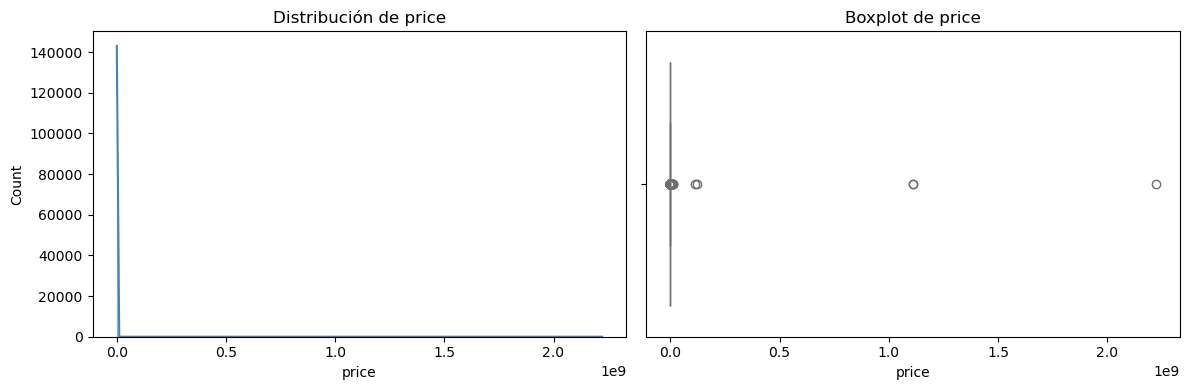

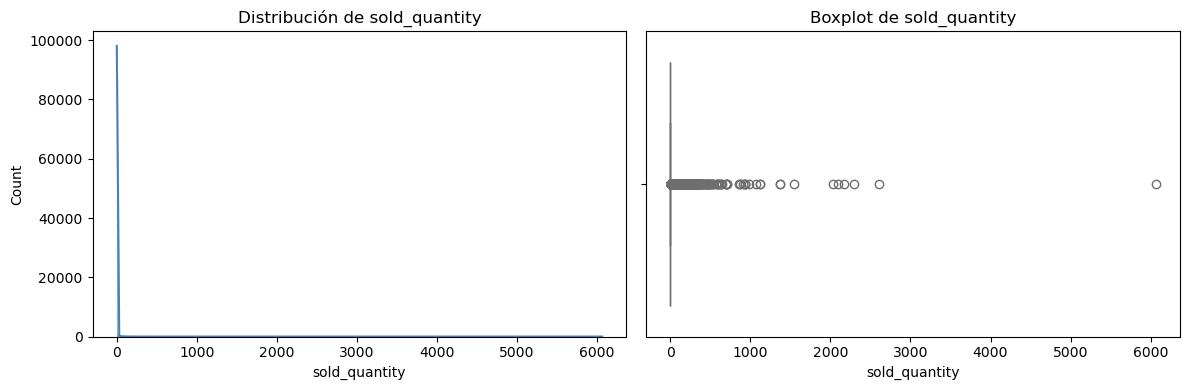

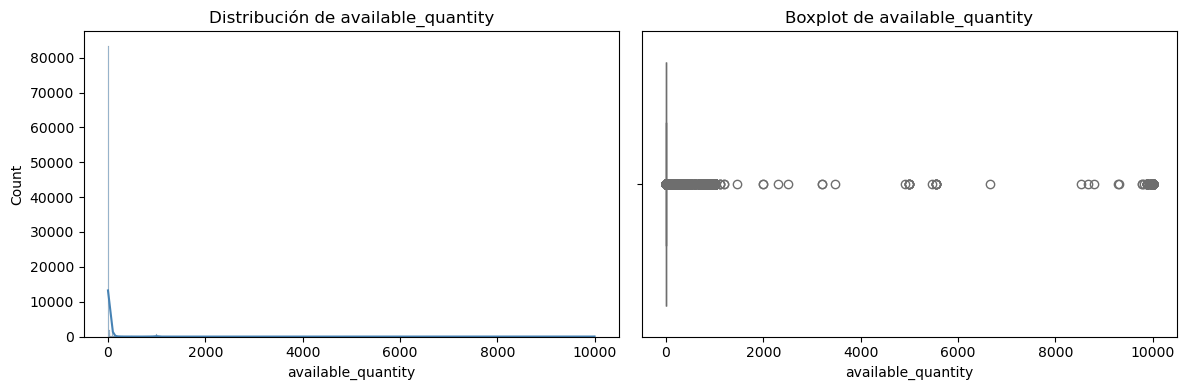

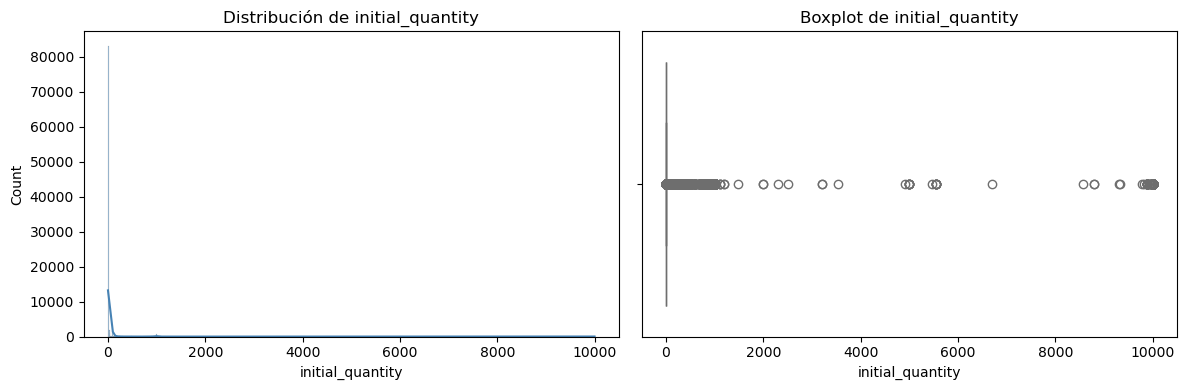

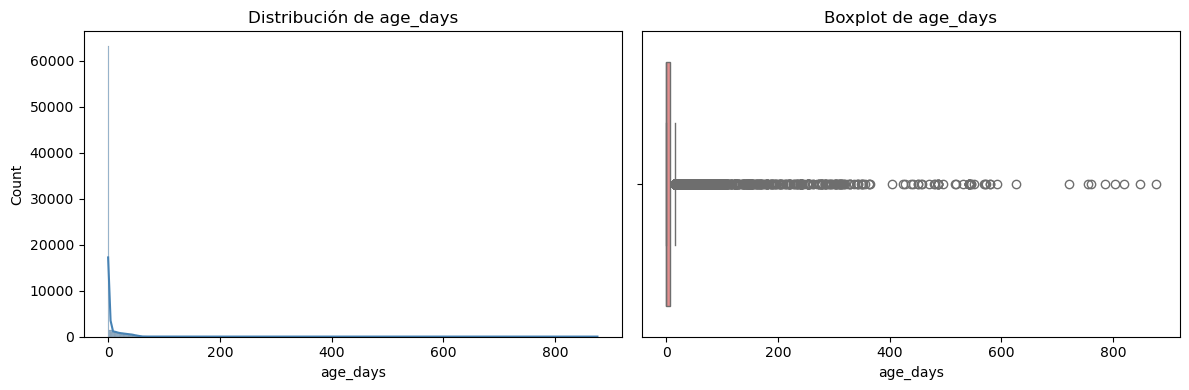

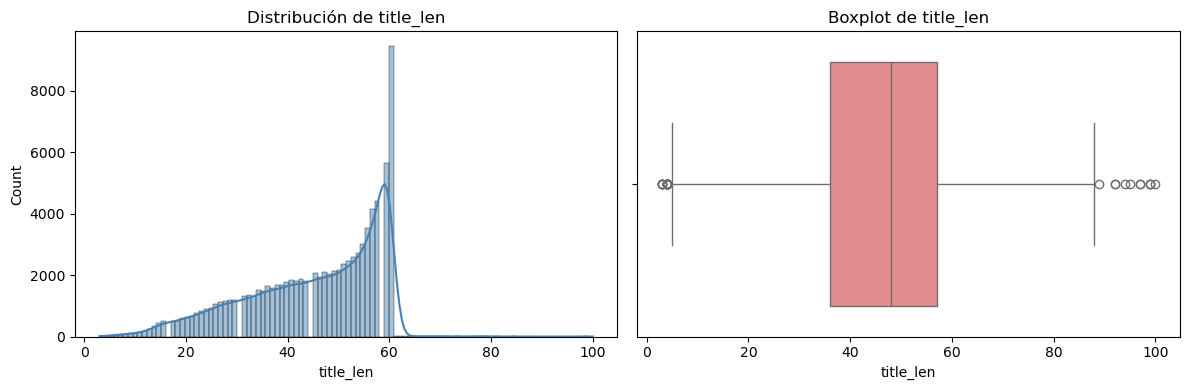

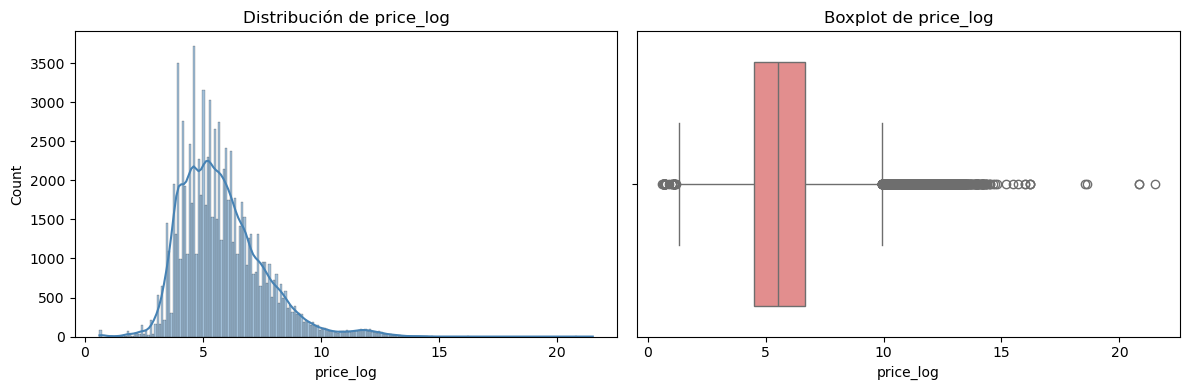

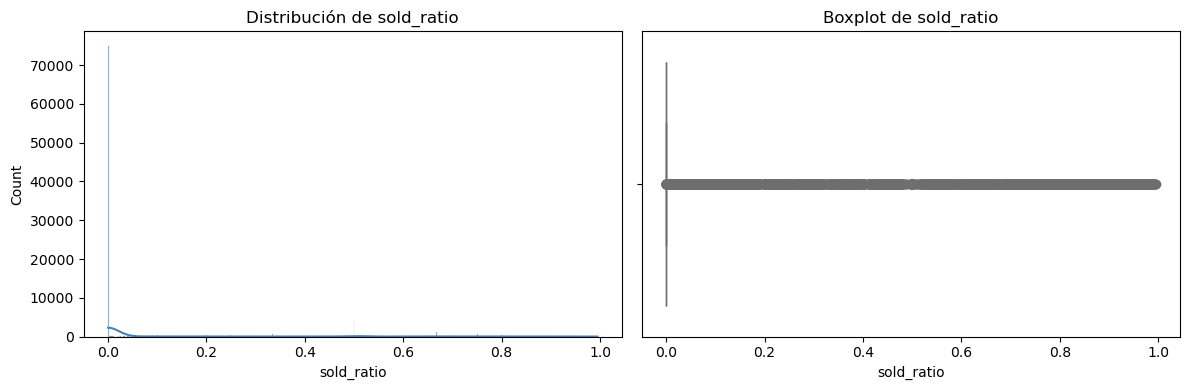

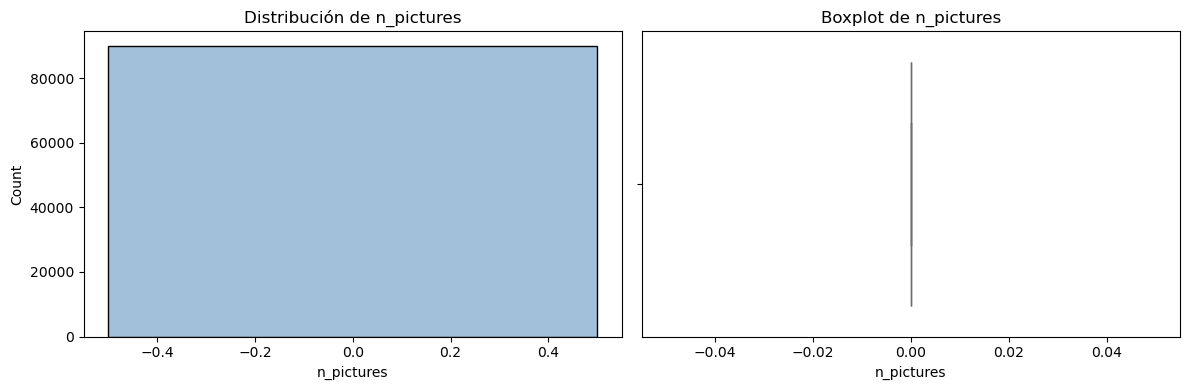

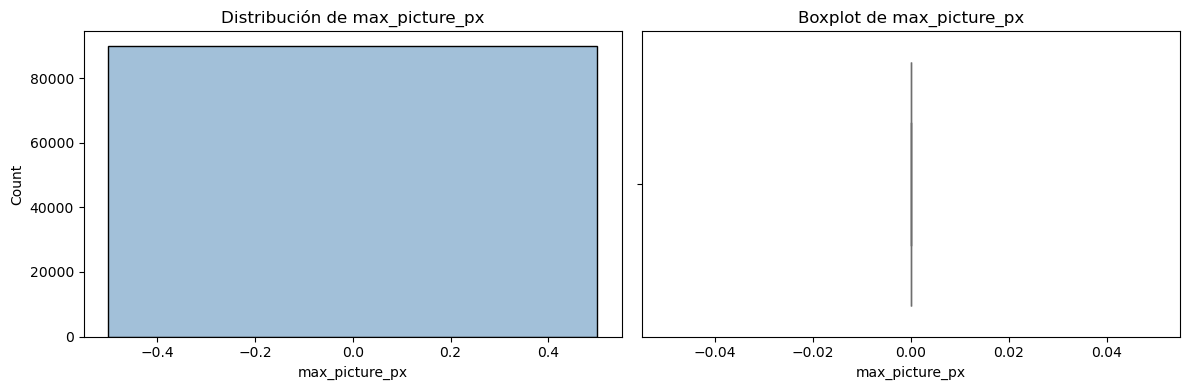

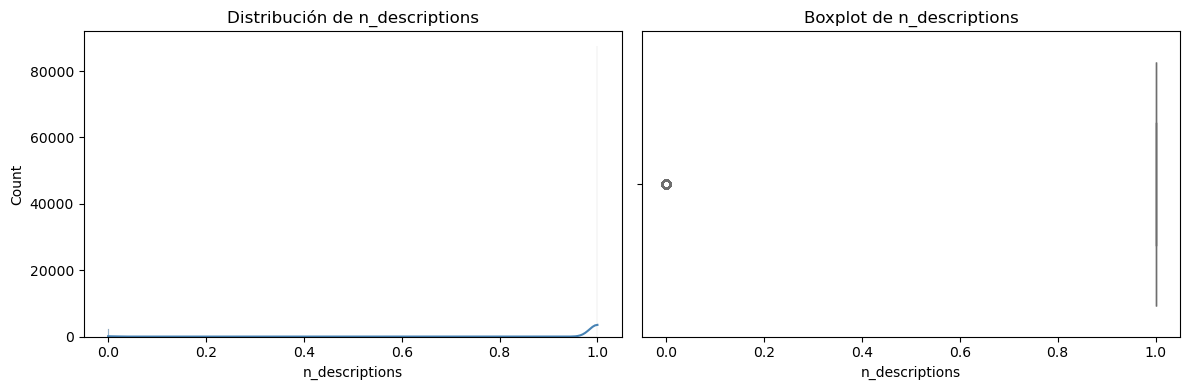

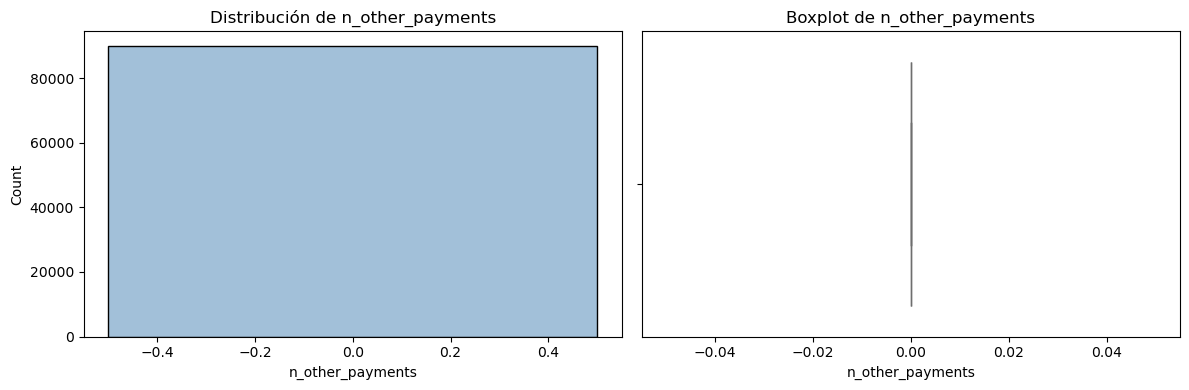

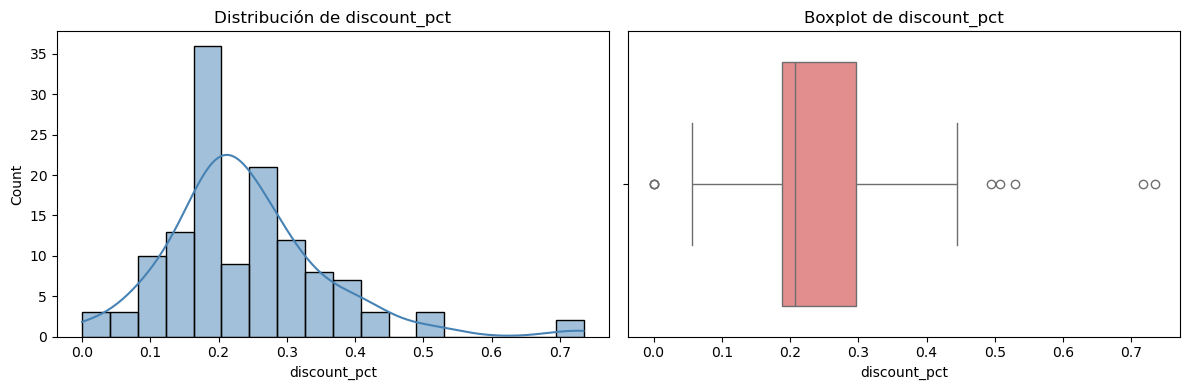

In [16]:
# Seleccionar columnas numéricas
num_cols = X_train_df.select_dtypes(include=["number"]).columns

# Estadísticas descriptivas
stats = X_train_df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
stats["missing"] = X_train_df[num_cols].isna().sum()
stats["missing_pct"] = X_train_df[num_cols].isna().mean() * 100

# Umbrales IQR para outliers (por fila/variable)
stats["IQR"] = stats["75%"] - stats["25%"]
stats["low_thr"]  = stats["25%"] - 1.5 * stats["IQR"]
stats["high_thr"] = stats["75%"] + 1.5 * stats["IQR"]

# Redondeo para legibilidad
stats_round = stats.round(2)

# Función de estilo: resalta min/max si traspasan umbrales IQR
def highlight_outliers(row):
    styles = [""] * len(row)
    cols = list(stats_round.columns)
    try:
        i_min = cols.index("min")
        i_max = cols.index("max")
        i_low = cols.index("low_thr")
        i_high = cols.index("high_thr")
        # Amarillo suave si min < low_thr o max > high_thr
        if pd.notna(row["min"]) and pd.notna(row["low_thr"]) and row["min"] < row["low_thr"]:
            styles[i_min] = "background-color: #fff3cd"  # amarillo
        if pd.notna(row["max"]) and pd.notna(row["high_thr"]) and row["max"] > row["high_thr"]:
            styles[i_max] = "background-color: #fff3cd"
    except Exception:
        pass
    return styles

# Styler con gradientes + outliers + formato
#styled_stats = (
#    stats_round.style
#    .apply(highlight_outliers, axis=1)
#    .background_gradient(cmap="Blues", subset=["mean", "std", "50%"])   # métricas centrales
#    .background_gradient(cmap="Reds", subset=["missing", "missing_pct"])  # faltantes
#    .format({"missing_pct": "{:.1f}%"})
#    .set_caption("Estadísticas descriptivas de variables numéricas (IQR para outliers)")
#)

#display(styled_stats)

# ================================
# Gráficos univariados (hist + box)
# ================================
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histograma con KDE
    sns.histplot(X_train_df[col].dropna(), kde=True, ax=axes[0], color="steelblue")
    axes[0].set_title(f"Distribución de {col}")

    # Boxplot
    sns.boxplot(x=X_train_df[col], ax=axes[1], color="lightcoral")
    axes[1].set_title(f"Boxplot de {col}")

    plt.tight_layout()
    plt.show()


**Insights**
- Se observa mayor cantidad de outliers en las variables: 'price', 'sold_quantity', 'available_quantity', 'initial_quantity',  'age_days', 'price_log', 'sold_ratio'.
- Y en menor cantidad se observan outliers en la variable 'title_len'.
- Por el momento se deciden dejar dichos outliers, hasta realizar un análisis multivariado con respecto a la variable target y ver su correlación.
- Variables numéricas con gran amplitud serán escaladas/normalizadas.
- También analizaremos su varianza y multicolinealidad, para ver si hay variables a eliminar.

## 5. Multivariate analysis

### 5.1 Correlation of numerical characteristics vs. the target

**Constant variables**

In [17]:
# Constant variables, delete for the input model
print(X_train_df['n_pictures'].value_counts())
print(X_train_df['max_picture_px'].value_counts())
print(X_train_df['n_other_payments'].value_counts())

n_pictures
0.0    90000
Name: count, dtype: int64
max_picture_px
0.0    90000
Name: count, dtype: int64
n_other_payments
0.0    90000
Name: count, dtype: int64


**Correlation matrix**

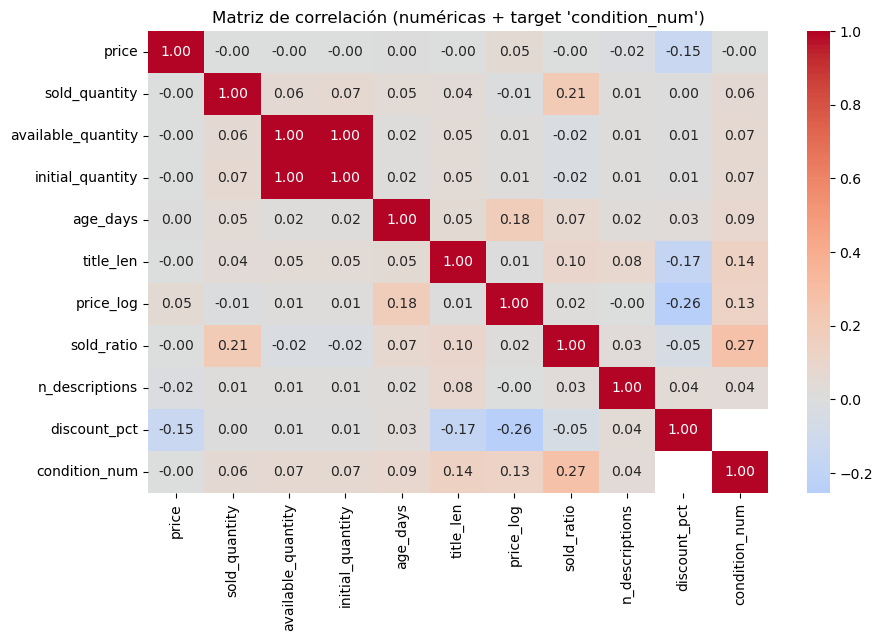

In [18]:
# 1) Crear target binario (1 = new, 0 = used)
X_train_df["condition_num"] = (
    X_train_df["condition"].astype(str).str.lower() == "new"
).astype(int)

# 2) Filtrar solo variables numéricas
df_num = X_train_df.select_dtypes(include=["number"])

# 3) Eliminar columnas sin datos (todo NaN) o con varianza cero
df_num = df_num.dropna(axis=1, how="all")     # quita columnas completamente vacías
df_num = df_num.loc[:, df_num.nunique() > 1] # opcional: elimina columnas constantes

# 4) Calcular matriz de correlación
corr = df_num.corr()

# 5) Visualizar con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación (numéricas + target 'condition_num')")
plt.show()


**Delete multicollinearity variables**

In [19]:
# 1) Crear target binario si no existe
if "condition_num" not in X_train_df.columns:
    X_train_df["condition_num"] = (
        X_train_df["condition"].astype(str).str.lower() == "new"
    ).astype(int)

# 2) Tomar solo numéricas (ya sin nulos completos ni constantes)
df_num = X_train_df.select_dtypes(include=["number"])
print(df_num.columns)
df_num = df_num.dropna(axis=1, how="all")
df_num = df_num.loc[:, df_num.nunique() > 1]

# 3) Calcular matriz de correlación
corr_matrix = df_num.corr().abs()

# 4) Seleccionar columnas a eliminar por alta correlación
# umbral de correlación (ej. 0.9)
threshold = 0.9

# Crear máscara triangular para no repetir pares
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Columnas con correlación alta
to_drop = [
    column for column in upper.columns if any(upper[column] > threshold)
]

# 5) DataFrame limpio de multicolinealidad
df_num_reduced = df_num.drop(columns=to_drop)

print("Variables eliminadas por alta correlación:", to_drop)
print("Variables finales:", df_num_reduced.columns.tolist())


Index(['price', 'sold_quantity', 'available_quantity', 'initial_quantity',
       'age_days', 'title_len', 'price_log', 'sold_ratio', 'n_pictures',
       'max_picture_px', 'n_descriptions', 'n_other_payments', 'discount_pct',
       'condition_num'],
      dtype='object')
Variables eliminadas por alta correlación: ['initial_quantity']
Variables finales: ['price', 'sold_quantity', 'available_quantity', 'age_days', 'title_len', 'price_log', 'sold_ratio', 'n_descriptions', 'discount_pct', 'condition_num']


**Insights**
- No tener en cuenta para el modelo las variables constantes (varianza cero), ya que no aportan información al modelo:
    - `n_pictures`
    - `max_picture_px`
    - `n_other_payments`
- Eliminación de la multicolinealidad. La idea es que si dos variables están altamente correlacionadas (p. ej., corr > 0,9), solo nos queda una:
- Eliminamos `initial_quantity` porque está altamente correlacionada con `available_quantity`.

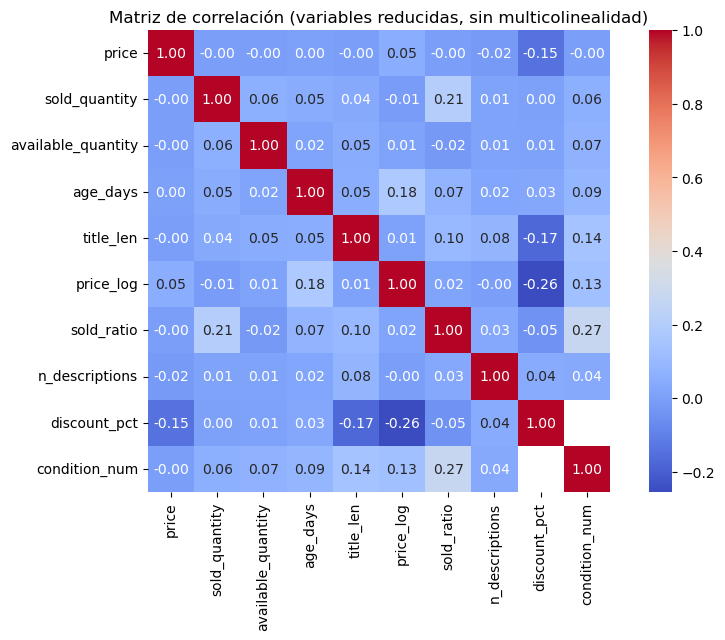

In [20]:
# --- Heatmap de la nueva matriz de correlación con las variables sin multicolinealidad---
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_num_reduced.corr(),
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Matriz de correlación (variables reducidas, sin multicolinealidad)")
plt.show()


**Filter the variables that really provide a signal regarding the target.**

In [21]:

# Paso 1: Crear el target binario
y_bin = (y_train_df.squeeze().astype(str).str.lower() == "new").astype(int).rename("condition_new")

# Paso 2: Concatenar con X
df_num = pd.concat([X_train_df, y_bin], axis=1).select_dtypes(include=["number"])

# Paso 3: Calcular correlación con el target
corr_target = df_num.corr()["condition_new"].drop("condition_new")

# Excluir variables no deseadas
excluir = ["condition_num", "initial_quantity"]
corr_target = corr_target.drop(labels=[c for c in excluir if c in corr_target.index], errors="ignore")

# Paso 4: Filtrar por un umbral mínimo de correlación
umbral = 0.05   # ajustá este valor a tu criterio
corr_filtrada = corr_target[abs(corr_target) > umbral].sort_values(key=abs, ascending=False)

print("Variables más correlacionadas con el target:")
print(corr_filtrada)


Variables más correlacionadas con el target:
sold_ratio            0.269537
title_len             0.142698
price_log             0.129782
age_days              0.085438
available_quantity    0.071967
sold_quantity         0.061176
Name: condition_new, dtype: float64


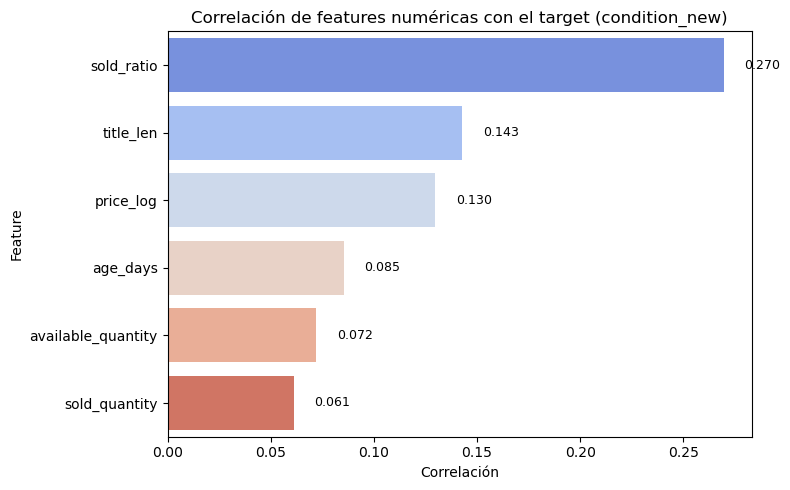

In [22]:
# --- Heatmap de la nueva matriz de correlación con las variables con alta correlación con el target---

# Gráfico con seaborn (usando hue para aplicar palette sin warning)
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=corr_filtrada.values,
    y=corr_filtrada.index,
    hue=corr_filtrada.index,   # asignamos hue = y
    palette="coolwarm",
    dodge=False,
    legend=False               # ocultar la leyenda redundante
)

# Agregar etiquetas de correlación
for i, v in enumerate(corr_filtrada.values):
    ax.text(
        v + 0.01 if v >= 0 else v - 0.01,
        i,
        f"{v:.3f}",
        va="center",
        ha="left" if v >= 0 else "right",
        color="black",
        fontsize=9
    )

plt.title("Correlación de features numéricas con el target (condition_new)")
plt.xlabel("Correlación")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Keep the numerical variables with high correlation:**
- sold_ratio
- title_len
- price_log
- age_days
- available_quantity
- sold_quantity

In [23]:
num_var_keep = ['sold_ratio', 'title_len', 'price_log', 'age_days', 'available_quantity', 'sold_quantity']

### 5.2 Analysis of categorical variables with respect to the target

In [24]:
def plot_cat_bool_props(X_train_df, y_bin, order_by="frequency"):
    """
    Visualiza proporciones de condition_new para variables categóricas y booleanas.
    Primero se grafican las categóricas, luego las booleanas.
    
    Parámetros
    ----------
    X_train_df : pd.DataFrame
        Features de entrenamiento.
    y_bin : pd.Series
        Target binario (1=new, 0=used).
    order_by : {"frequency", "new_proportion"}, default="frequency"
        Criterio de ordenamiento de categorías no booleanas.
    """

    # Unir features con target
    df_cat = X_train_df.join(y_bin)

    # Separar categóricas y booleanas
    cat_cols = [
        c for c in df_cat.select_dtypes(include=["object", "category"]).columns
        if c != "condition"
    ]
    bool_cols = [
        c for c in df_cat.select_dtypes(include=["bool"]).columns
        if c != "condition"
    ]

    all_cols = cat_cols + bool_cols
    n_cols = 1
    n_rows = (len(all_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))

    for ax, col in zip(axes.flatten(), all_cols):
        prop_df = (
            df_cat.groupby(col)["condition_new"]
            .value_counts(normalize=True)
            .rename("proportion")
            .reset_index()
        )

        # Orden de categorías
        if col in bool_cols:
            order = [False, True]
        else:  # categóricas
            if order_by == "frequency":
                order = df_cat[col].value_counts().index[:10]
            elif order_by == "new_proportion":
                order = (
                    prop_df[prop_df["condition_new"] == 1]
                    .sort_values("proportion", ascending=False)[col]
                    .head(10)
                )
            else:
                raise ValueError("order_by debe ser 'frequency' o 'new_proportion'")

        # Graficar barras
        sns.barplot(
            data=prop_df,
            x=col,
            y="proportion",
            hue="condition_new",
            order=order,
            ax=ax
        )

        # Anotaciones
        for container in ax.containers:
            ax.bar_label(
                container,
                labels=[f"{h*100:.1f}%" for h in container.datavalues],
                label_type="edge",
                fontsize=9
            )

        ax.set_title(f"Proporción de {col} según condition_new", pad=15, fontsize=12)
        ax.set_ylabel("Proporción")
        ax.set_xlabel(col)
        ax.tick_params(axis="x", rotation=45)

    # Eliminar ejes vacíos si sobran
    for i in range(len(all_cols), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


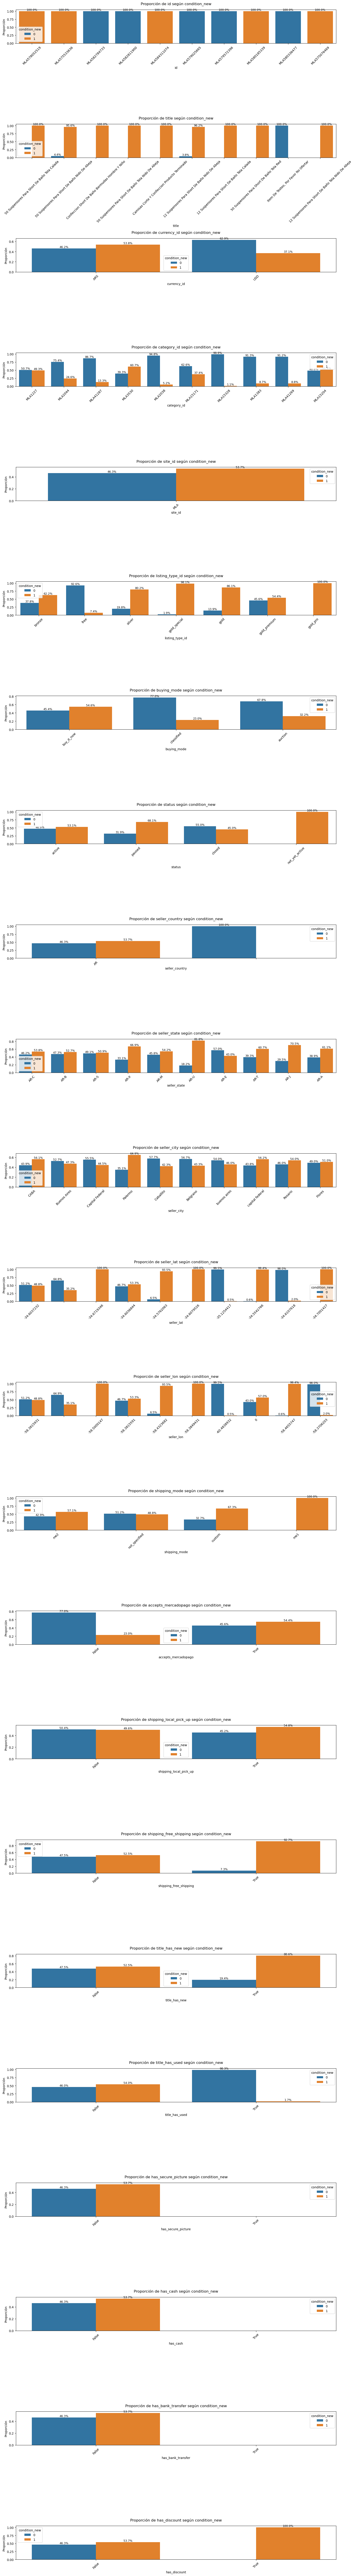

In [25]:
# Orden por frecuencia (default)
plot_cat_bool_props(X_train_df, y_bin, order_by="frequency")

In [26]:
X_train_df['title'].nunique() # Eliminar la variable, tiene mucha variabilidad

89008

In [27]:
X_train_df['buying_mode'].value_counts() # Hay variaciones con respecto al target, dejar la variable

buying_mode
buy_it_now    87311
classified     1982
auction         707
Name: count, dtype: int64

In [28]:
X_train_df['currency_id'].value_counts() # Hay variaciones con respecto al target, dejar la variable

currency_id
ARS    89496
USD      504
Name: count, dtype: int64

In [29]:
X_train_df['category_id'].nunique() # Eliminar la variable, tiene mucha variabilidad

10491

In [30]:
X_train_df['site_id'].value_counts() # Eliminar la variable, ya que es constante

site_id
MLA    90000
Name: count, dtype: int64

In [31]:
X_test_df['site_id'].value_counts() # Eliminar la variable, ya que es constante

site_id
MLA    10000
Name: count, dtype: int64

In [32]:
X_train_df['listing_type_id'].value_counts() # Hay variaciones con respecto al target, dejar la variable

listing_type_id
bronze          56904
free            19260
silver           8195
gold_special     2693
gold             2170
gold_premium      765
gold_pro           13
Name: count, dtype: int64

In [33]:
X_train_df['status'].value_counts() # Hay variaciones con respecto al target, dejar la variable

status
active            86116
paused             3863
closed               20
not_yet_active        1
Name: count, dtype: int64

In [34]:
X_train_df['seller_country'].value_counts() # Es casi constante con Country=AR, eliminar la variable

seller_country
AR    89999
          1
Name: count, dtype: int64

In [35]:
X_train_df['seller_state'].value_counts() # Hay variaciones con respecto al target, pero tiene muchas categorías.

seller_state
AR-C    52143
AR-B    31482
AR-S     2398
AR-X     1727
AR-M      400
AR-U      335
AR-E      249
AR-T      214
AR-J      132
AR-A      131
AR-N      122
AR-R      119
AR-W      110
AR-Q       87
AR-L       70
AR-H       69
AR-D       56
AR-Y       33
AR-P       28
AR-G       26
AR-Z       22
AR-K       20
AR-F       16
AR-V       10
            1
Name: count, dtype: int64

In [36]:
X_train_df['seller_city'].nunique() # Eliminar la variable por su cardinalidad
# Se puede usar Frequency encoding: usar la cantidad de registros por ciudad.
# Otra alternativa: Agrupar ciudades poco frecuentes en una categoría "other".

3480

In [37]:
X_train_df['seller_lat'].nunique() # Eliminar la variable por su cardinalidad

24550

In [38]:
X_train_df['seller_lon'].nunique() # Eliminar la variable por su cardinalidad

24520

In [39]:
X_train_df['shipping_mode'].value_counts() # Hay variaciones con respecto al target, dejar la variable

shipping_mode
me2              46059
not_specified    40725
custom            3130
me1                 86
Name: count, dtype: int64

In [40]:
X_train_df['accepts_mercadopago'].value_counts() # Hay variaciones con respecto al target, dejar la variable

accepts_mercadopago
True     88018
False     1982
Name: count, dtype: int64

In [41]:
X_train_df['shipping_local_pick_up'].value_counts() # Hay variaciones mínimas con respecto al target, eliminar la variable

shipping_local_pick_up
True     71577
False    18423
Name: count, dtype: int64

In [42]:
X_train_df['shipping_free_shipping'].value_counts() # Hay variaciones con respecto al target, dejar la variable

shipping_free_shipping
False    87303
True      2697
Name: count, dtype: int64

In [43]:
X_train_df['has_cash'].value_counts() # Es constante en False, eliminar la variable

has_cash
False    90000
Name: count, dtype: int64

In [44]:
X_train_df['has_bank_transfer'].value_counts() # Es constante en False, eliminar la variable

has_bank_transfer
False    90000
Name: count, dtype: int64

In [45]:
X_train_df['has_discount'].value_counts() # Hay variaciones con respecto al target, dejar la variable

has_discount
False    89870
True       130
Name: count, dtype: int64

In [46]:
X_train_df['has_secure_picture'].value_counts() # Constante, eliminar la variable

has_secure_picture
False    90000
Name: count, dtype: int64

**Variables eliminadas y motivo:**
- title: tiene mucha variabilidad (89008 casos únicos).
- price: baja correlación con el target.
- category_id: tiene mucha variabilidad (10491 casos únicos).
- site_id: es constante ('MLA').   
- initial_quantity: Eliminamos `initial_quantity` porque está altamente correlacionada con `available_quantity`.
- date_created: Se deja la variable derivada 'age_days'.
- last_updated: Se deja la variable derivada 'age_days'.
- stop_time: Se deja la variable derivada 'age_days'.
- start_time: Se deja la variable derivada 'age_days'.
- seller_country: Es casi constante con Country=AR, y 1 caso con ''.
- seller_state: tiene variabilidad (25 casos únicos). Se podría pensar en dejar las más frecuentes y poner una categoría 'others'
- seller_city: tiene mucha variabilidad (89008 casos únicos).
- seller_lat: tiene mucha variabilidad.
- seller_long: tiene mucha variabilidad.
- shipping_local_pick_up: Hay variaciones mínimas con respecto al target, eliminar la variable.
- n_descriptions: baja correlación con el target.
- n_other_payments: es constante, varianza cero.
- n_pictures: es constante, varianza cero.
- has_secure_picture: es constante en False, varianza cero.
- max_picture_px: es constante, varianza cero.
- has_cash: Es constante en False.
- has_bank_transfer: Es constante en False.
- discount_pct: casi nula correlación con el target.



In [47]:
num_var_keep = ['sold_ratio', 'title_len', 'price_log', 'age_days', 'available_quantity', 'sold_quantity']
cat_var_keep = ['currency_id', 'listing_type_id', 'buying_mode', 'status', 'accepts_mercadopago',\
                 'shipping_mode']
bool_var_keep = ['shipping_free_shipping', 'title_has_new', 'title_has_used', 'has_discount']
target_col_keep = ['condition_num']

X_train_columns = num_var_keep + cat_var_keep + bool_var_keep + target_col_keep
X_test_columns = num_var_keep + cat_var_keep + bool_var_keep

In [48]:
X_train_df_filtered = X_train_df[X_train_columns]
print(len(X_train_df_filtered.columns))
X_train_df_filtered.columns

17


Index(['sold_ratio', 'title_len', 'price_log', 'age_days',
       'available_quantity', 'sold_quantity', 'currency_id', 'listing_type_id',
       'buying_mode', 'status', 'accepts_mercadopago', 'shipping_mode',
       'shipping_free_shipping', 'title_has_new', 'title_has_used',
       'has_discount', 'condition_num'],
      dtype='object')

In [49]:
X_test_df_filtered = X_test_df[X_test_columns]
print(len(X_test_df_filtered.columns))
X_test_df_filtered.columns

16


Index(['sold_ratio', 'title_len', 'price_log', 'age_days',
       'available_quantity', 'sold_quantity', 'currency_id', 'listing_type_id',
       'buying_mode', 'status', 'accepts_mercadopago', 'shipping_mode',
       'shipping_free_shipping', 'title_has_new', 'title_has_used',
       'has_discount'],
      dtype='object')

## 6. NUMERICAL VARIABLES TRANSFORMATION

Ya que la mayoría de las variables numéricas están altamente sesgadas y presentan outliers extremos, utilizaremos métodos de transformación y escalado para mejorar la performance de los modelos.
La transformación debe realizarse tanto en train como en test.

In [51]:
# Check nulls in X_train_df_filtered
nulls_train = (X_train_df_filtered.isna().mean() * 100)
nulls_train = nulls_train[nulls_train > 0].sort_values(ascending=False)
nulls_train

Series([], dtype: float64)

In [52]:
# Check nulls in X_test_df_filtered
nulls_test = (X_test_df_filtered.isna().mean() * 100)
nulls_test = nulls_test[nulls_test > 0].sort_values(ascending=False)
nulls_test

Series([], dtype: float64)

In [53]:
# Escalar las variables numéricas de X_train_df_filtered con RobutScaler
X_train_df_filtered_scaled = scale_numeric_features(X_train_df_filtered, exclude_cols=['shipping_free_shipping', 'title_has_new', 'title_has_used', 'has_discount', 'condition_num'])

In [54]:
# Escalar las variables numéricas de X_test_df_filtered con RobutScaler
X_test_df_filtered_scaled = scale_numeric_features(X_test_df_filtered, exclude_cols=['shipping_free_shipping', 'title_has_new', 'title_has_used', 'has_discount'])

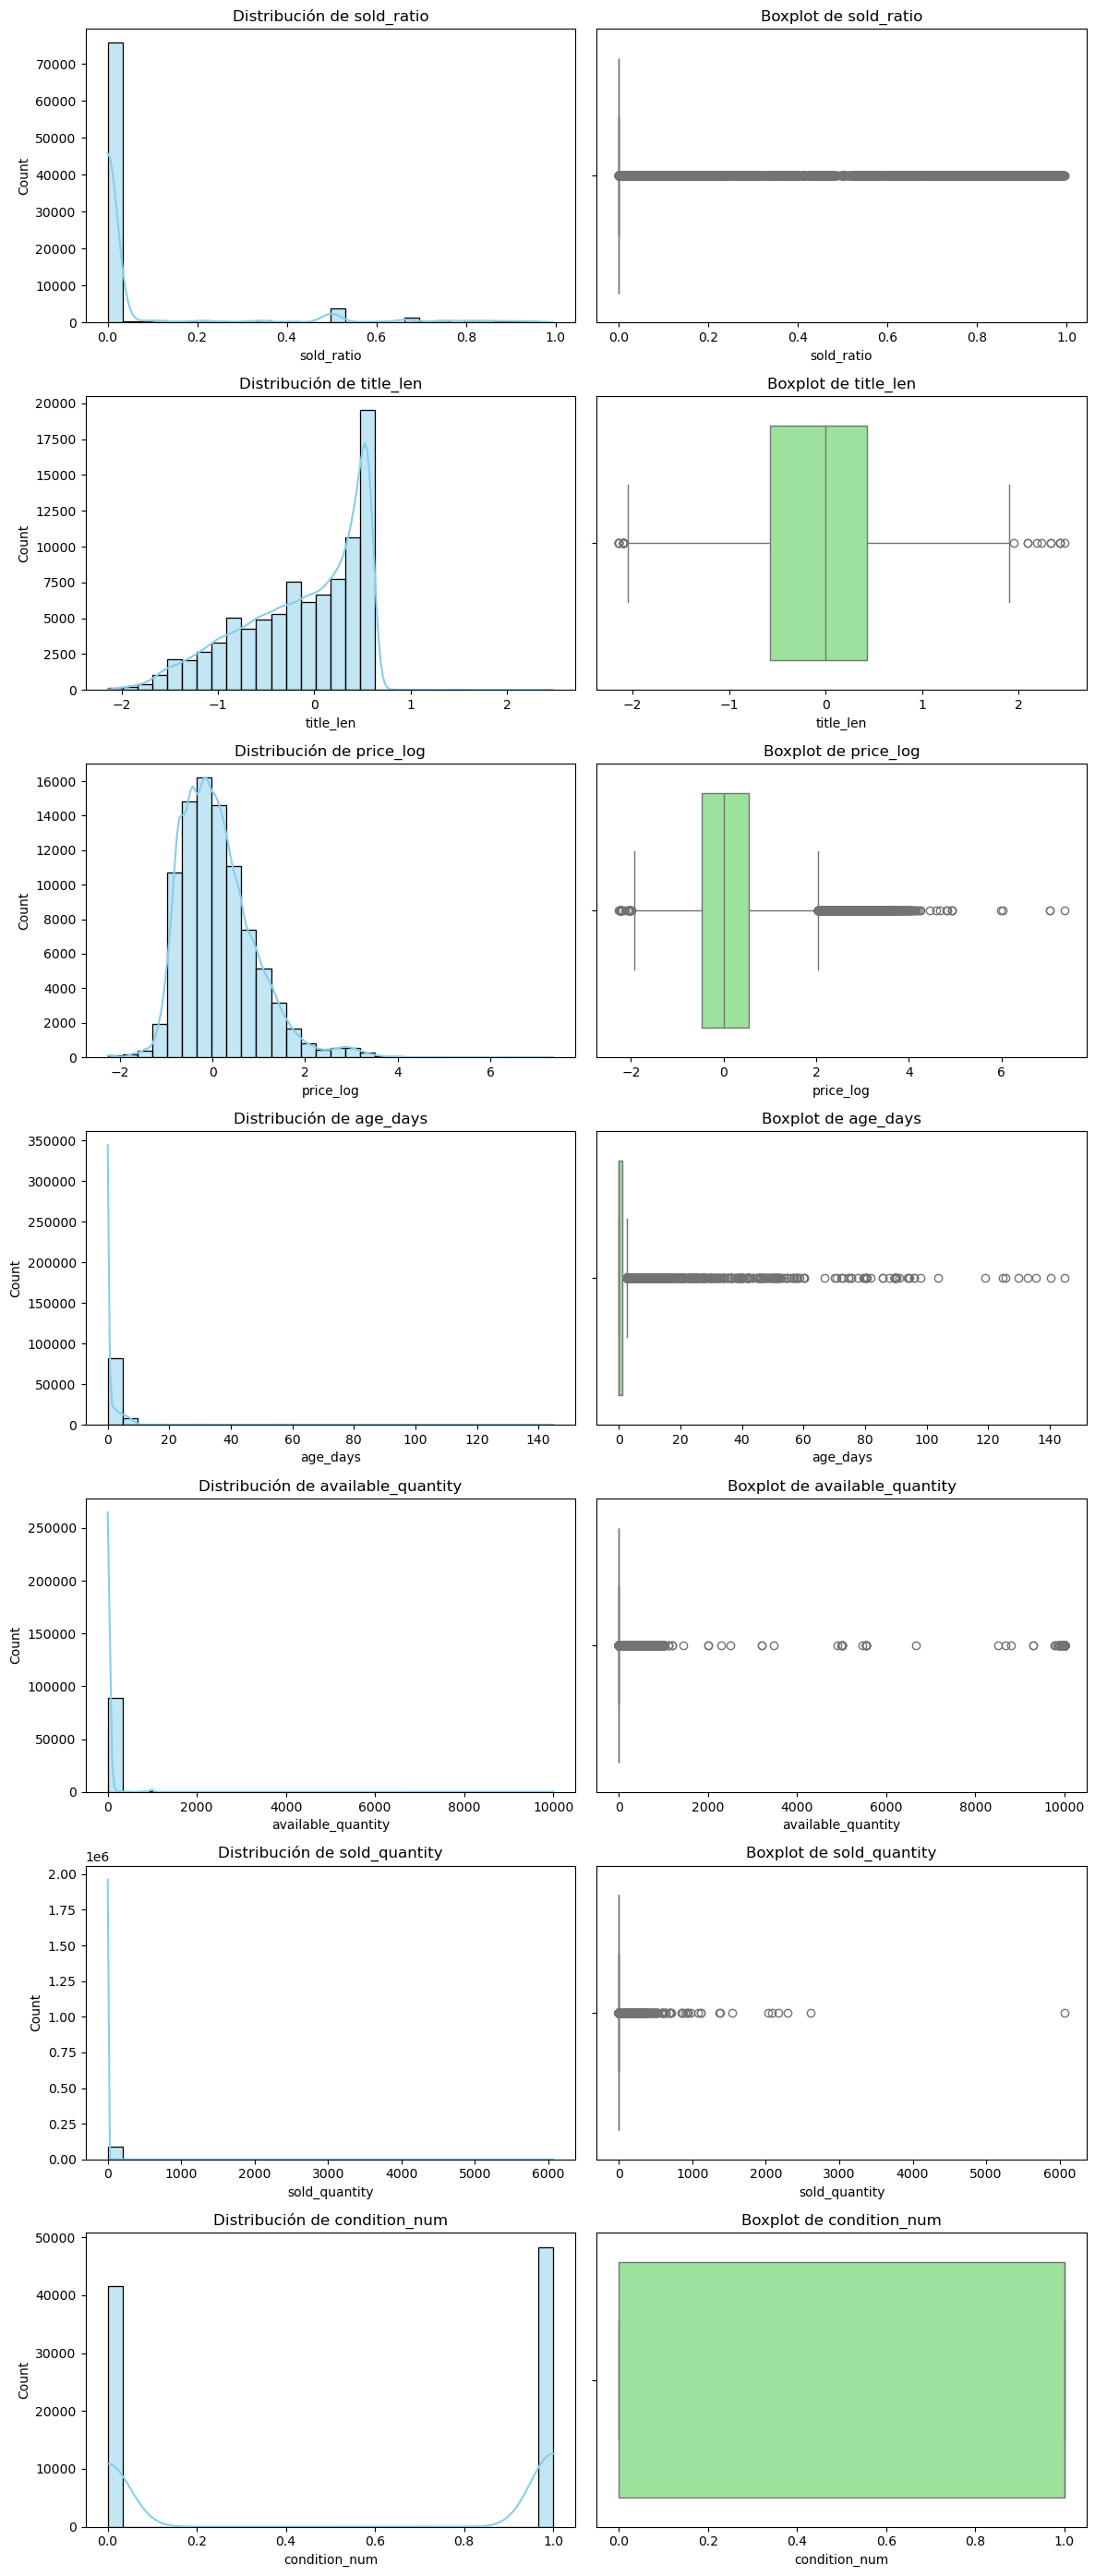

In [55]:
# Visualizar las distribuciones de las variables numéricas escaladas
plot_numeric_distributions(X_train_df_filtered_scaled, bins=30)

**Posibles mejoras**
- Tratamiento de outliers, ya que después de escalar, siguen reflejándose en algunas variables numéricas.

## 7. CATEGORICAL VARIABLES ENCODING

- Debemos pasar las variables categóricas a numéricas por medio de encoding, ya que los modelos trabajan con variables numéricas.
- Aplicarlo tanto a train como a test.
- Codificamos todas las variables categóricas de un usando OneHotEncoder con drop='first' para evitar multicolinealidad.

In [56]:
X_train_df_filtered_scaled_encod = encode_categoricals(X_train_df_filtered_scaled)
len(X_train_df_filtered_scaled_encod.columns)

27

In [57]:
X_test_df_filtered_scaled_encod = encode_categoricals(X_test_df_filtered_scaled)
len(X_test_df_filtered_scaled_encod.columns)


24

In [58]:
X_train_df_filtered_scaled_encod.columns

Index(['sold_ratio', 'title_len', 'price_log', 'age_days',
       'available_quantity', 'sold_quantity', 'accepts_mercadopago',
       'shipping_free_shipping', 'title_has_new', 'title_has_used',
       'has_discount', 'condition_num', 'currency_id_USD',
       'listing_type_id_free', 'listing_type_id_gold',
       'listing_type_id_gold_premium', 'listing_type_id_gold_pro',
       'listing_type_id_gold_special', 'listing_type_id_silver',
       'buying_mode_buy_it_now', 'buying_mode_classified', 'status_closed',
       'status_not_yet_active', 'status_paused', 'shipping_mode_me1',
       'shipping_mode_me2', 'shipping_mode_not_specified'],
      dtype='object')

In [59]:
# Reordenar la columna 'condition_num'
X_train_df_filtered_scaled_encod = X_train_df_filtered_scaled_encod[
    [c for c in X_train_df_filtered_scaled_encod.columns if c != "condition_num"] + ["condition_num"]
]

In [60]:
# Renombrar la columna 'condition_num' con 'condition' para que coincida con test
X_train_df_filtered_scaled_encod = X_train_df_filtered_scaled_encod.rename(columns={"condition_num": "condition"})

In [61]:
X_train_df_filtered_scaled_encod['condition'].value_counts() 
# Vemos que el dataset de entrenamiento no está desbalanceado en un porcentaje alto

condition
1    48352
0    41648
Name: count, dtype: int64

## 8. BASELINE MODEL

### 8.1 Model Metrics

En el caso que estamos prediciendo si un item en venta es nuevo/usado, tenemos dos enfoques posibles:
- Si el modelo se va a usar para detectar productos nuevos con confianza, conviene priorizar alto el 'precision'.
- Si en cambio lo importante es no perder ningún producto nuevo (aunque se cuelen usados), entonces priorizamos tener alto el 'recall'.

Como no tenemos claro estos objetivos de negocio vamos a optar por una métrica balanceada:
- **Maximizar F1-score**: Se elige el umbral donde la combinación de precision y recall está más balanceada. Es decir, queremos un equilibrio entre detectar la mayor cantidad posible de productos nuevos (recall), pero sin etiquetar demasiados productos usados como si fueran nuevos (precision)

Aplicamos como modelo “Baseline”, una **Regresión Logística**, para predecir la variable binaria “condition_num”. Ya que es un modelo simple, rápido e interpretable. Y suele ser una buena base para problemas binarios.

>>> Mejor threshold por F1: 0.4860 | F1=0.7995 | Precision=0.7543 | Recall=0.8505

=== Logistic Regression best F1 threshold ===
ROC-AUC: 0.8570843139992955

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      4594
           1       0.75      0.85      0.80      5406

    accuracy                           0.77     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.77      0.77     10000

Confusion Matrix:


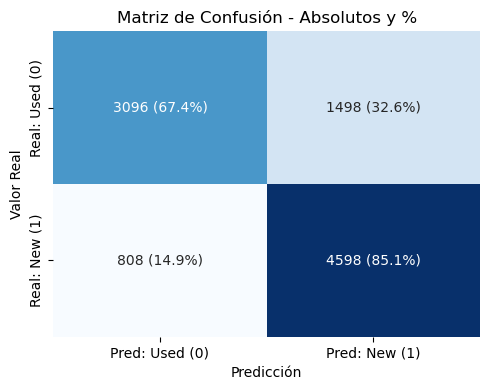

In [63]:
# Reutilizar los dataframes ya cargados:
X_train = X_train_df_filtered_scaled_encod.drop(columns=["condition"], errors="ignore").copy()
X_test  = X_test_df_filtered_scaled_encod.drop(columns=["condition"], errors="ignore").copy()

def binarize_condition(df_or_series):
    s = df_or_series["condition"] if isinstance(df_or_series, pd.DataFrame) else df_or_series
    return s.astype(str).str.lower().map({"new": 1, "used": 0}).astype(int)

y_train = binarize_condition(y_train_df)
y_test  = binarize_condition(y_test_df)

feature_names = X_train.columns.tolist()
X_test_aligned = X_test.reindex(columns=feature_names, fill_value=0)

# Usamos solver 'saga' (ya que la documentación indica que es más eficiente en alta dimensionalidad), con L2 por defecto
log_reg = LogisticRegression(
    solver="saga",       
    penalty="l2",
    C=0.5,                # más regularización (default=1.0). Si sigue el warning, prueba C=0.2
    max_iter=2000,        # más iteraciones
    tol=1e-3,             # tolerancia un poco más laxa
    random_state=42,
)

log_reg.fit(X_train, y_train)

y_proba = log_reg.predict_proba(X_test_aligned)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = (2 * precision[:-1] * recall[:-1]) / np.clip(precision[:-1] + recall[:-1], 1e-12, None)
best_idx = np.nanargmax(f1)
best_thr = thresholds[best_idx]
best_f1 = f1[best_idx]

y_pred_best = (y_proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

print(f">>> Mejor threshold por F1: {best_thr:.4f} | "
      f"F1={best_f1:.4f} | Precision={precision[best_idx]:.4f} | Recall={recall[best_idx]:.4f}")
print("\n=== Logistic Regression best F1 threshold ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, digits=2))
print("Confusion Matrix:")

# Matriz de Confusión - Texto con absolutos + porcentajes
labels = np.array([
    [f"{cm[0,0]} ({cm_percent[0,0]:.1f}%)", f"{cm[0,1]} ({cm_percent[0,1]:.1f}%)"],
    [f"{cm[1,0]} ({cm_percent[1,0]:.1f}%)", f"{cm[1,1]} ({cm_percent[1,1]:.1f}%)"]
])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", cbar=False,
            xticklabels=["Pred: Used (0)", "Pred: New (1)"],
            yticklabels=["Real: Used (0)", "Real: New (1)"])

plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Absolutos y %")
plt.tight_layout()
plt.show()


Conclusiones del modelo de regresión logística:

- TN (arriba-izquierda): un 67,4% de ítems usados fueron correctamente clasificados como usados, esto evita prometer “nuevo” cuando no lo es (protege la confianza).

- FP (arriba-derecha): un 32,6% de los usados fueron clasificados como nuevos, esto representa un costo de reputación (riesgo de falsas promesas). Pero el porcentaje es bajo o aceptable.

- FN (abajo-izquierda): un 14,9% de ítems nuevos fueron clasificados como usados, esto implica una pérdida de oportunidad (podríamos no destacar un producto que sí es nuevo).

- TP (abajo-derecha): un 85,1% de los ítems nuevos fueron correctamente clasificados, este es nuestro objetivo principal ya que quisiéramos promover productos nuevos.

- El modelo es mejor detectando productos nuevos que usados.

    - Alta recall (85%) en “new”: casi todos los productos nuevos reales se identifican como tal.

    - Esto es positivo si tu estrategia es destacar productos nuevos y evitar perderlos de vista.

- El costo está en algunos “usados” que se confunden como “nuevos” (precisión 75% en clase “new”).

    - Estos falsos positivos son un riesgo reputacional: mostrar productos usados como “nuevos” puede erosionar la confianza del cliente.

- Balance general aceptable (77% accuracy, 0.80 F1 en “new”):

    - El modelo encuentra un compromiso entre no dejar escapar demasiados nuevos y no sobre-inflar la categoría.

    - El F1 se maximizó para dar equilibrio entre precisión y recall.

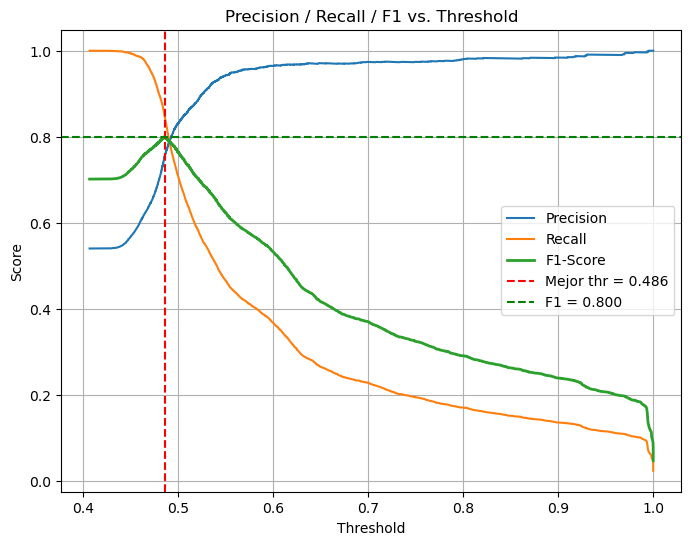

In [64]:
# ========= Plot Curva Precision / Recall / F1 vs Threshold =========
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1, label="F1-Score", linewidth=2)
plt.axvline(best_thr, color="red", linestyle="--", label=f"Mejor thr = {best_thr:.3f}")
plt.axhline(best_f1, color="green", linestyle="--", label=f"F1 = {best_f1:.3f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision / Recall / F1 vs. Threshold")
plt.legend(); plt.grid(True); plt.show()

**Feature imprtance Log Reg.**

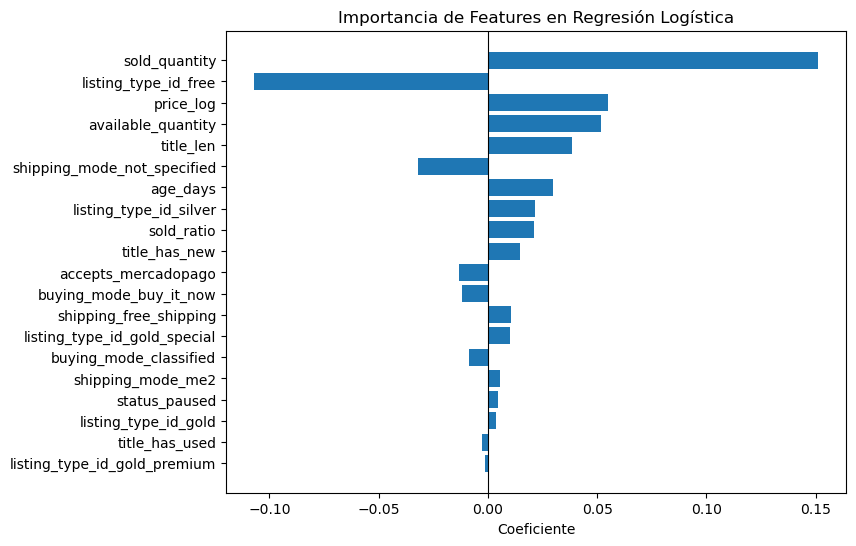

In [65]:
# Extraer coeficientes
coef = log_reg.coef_[0]

# Asociarlos con el nombre de las features
feature_importance = pd.DataFrame({
    "feature": X_train_df_filtered_scaled_encod.drop(columns=["condition"]).columns,
    "coefficient": coef,
    "abs_coefficient": np.abs(coef)
})

# Ordenar por importancia absoluta
feature_importance = feature_importance.sort_values(
    by="abs_coefficient", ascending=False
)

# Mostrar top-20
#print(feature_importance.head(20))

top_features = feature_importance.head(20)

plt.figure(figsize=(8,6))
plt.barh(top_features["feature"], top_features["coefficient"])
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Importancia de Features en Regresión Logística")
plt.xlabel("Coeficiente")
plt.gca().invert_yaxis()
plt.show()



- Los productos con alto volumen de ventas, precio más alto, gran stock y publicaciones pagas/pro son los que el modelo más fuertemente asocia a “nuevo”.

- En cambio, publicaciones con bajo stock, gratis, sin especificar envío, o con poca estructura en la publicación se asocian más a “usado”.


## 9. LigthGBM Model and metrics comparation

[LightGBM] [Info] Number of positive: 48352, number of negative: 41648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537244 -> initscore=0.149254
[LightGBM] [Info] Start training from score 0.149254
>>> LGBM — Mejor threshold por F1: 0.4762 | F1=0.8521 | Precision=0.8151 | Recall=0.8927
ROC-AUC: 0.9257608687424008

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4594
           1       0.82      0.89      0.85      5406

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.83      0.

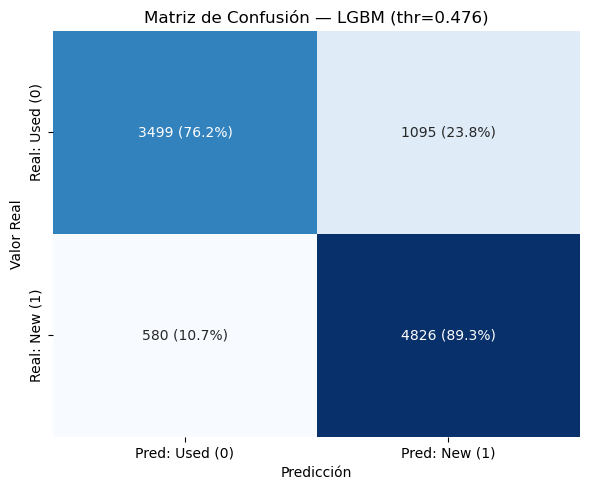

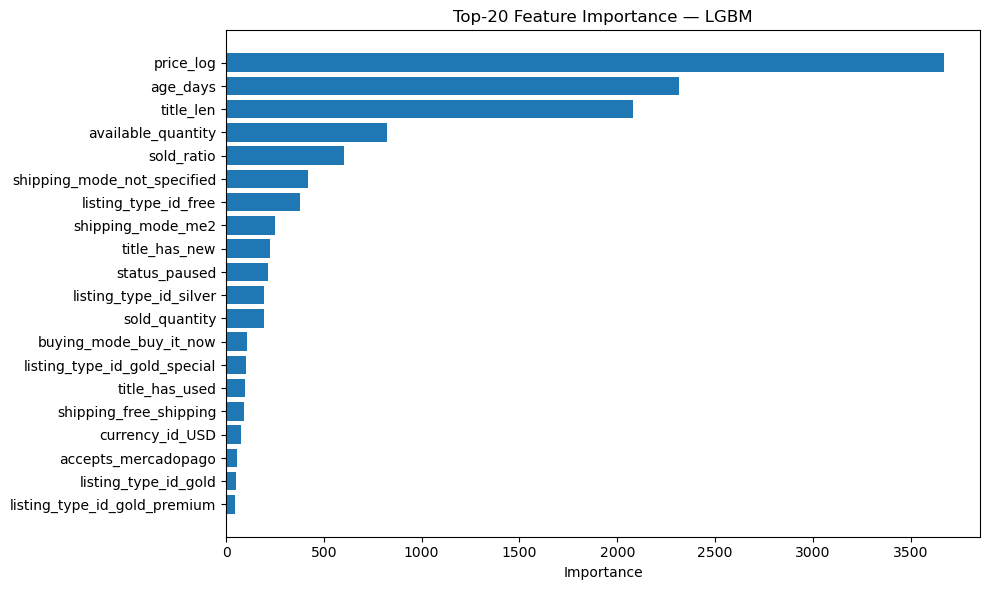

In [66]:
# Reutilizar los dataframes ya cargados:
X_train = X_train_df_filtered_scaled_encod.drop(columns=["condition"], errors="ignore").copy()
X_test  = X_test_df_filtered_scaled_encod.drop(columns=["condition"], errors="ignore").copy()

def binarize_condition(df_or_series):
    s = df_or_series["condition"] if isinstance(df_or_series, pd.DataFrame) else df_or_series
    return s.astype(str).str.lower().map({"new": 1, "used": 0}).astype(int)

y_train = binarize_condition(y_train_df)
y_test  = binarize_condition(y_test_df)

# Alinear columnas de test con las de train
feature_names = X_train.columns.tolist()
X_test_aligned = X_test.reindex(columns=feature_names, fill_value=0)

# ===== Modelo LGBM (parámetros básicos y rápidos) =====
lgbm = LGBMClassifier(
    n_estimators=400,        # sube/baja para más/menos capacidad
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
    # Si hay desbalance fuerte, podrías probar: class_weight="balanced"
)

lgbm.fit(X_train, y_train)

# ===== Predicción probabilística y threshold óptimo por F1 =====
y_proba = lgbm.predict_proba(X_test_aligned)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = (2 * precision[:-1] * recall[:-1]) / np.clip(precision[:-1] + recall[:-1], 1e-12, None)
best_idx = np.nanargmax(f1)
best_thr = thresholds[best_idx]
best_f1 = f1[best_idx]

y_pred_best = (y_proba >= best_thr).astype(int)

print(f">>> LGBM — Mejor threshold por F1: {best_thr:.4f} | "
      f"F1={best_f1:.4f} | Precision={precision[best_idx]:.4f} | Recall={recall[best_idx]:.4f}")
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, digits=2))

# ===== Matriz de confusión con porcentajes =====
cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

labels = np.array([
    [f"{cm[0,0]} ({cm_percent[0,0]:.1f}%)", f"{cm[0,1]} ({cm_percent[0,1]:.1f}%)"],
    [f"{cm[1,0]} ({cm_percent[1,0]:.1f}%)", f"{cm[1,1]} ({cm_percent[1,1]:.1f}%)"]
])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", cbar=False,
            xticklabels=["Pred: Used (0)", "Pred: New (1)"],
            yticklabels=["Real: Used (0)", "Real: New (1)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title(f"Matriz de Confusión — LGBM (thr={best_thr:.3f})")
plt.tight_layout()
plt.show()

# ===== Importancias (ganancia) opcional =====
imp = pd.DataFrame({"feature": feature_names, "importance": lgbm.feature_importances_}) \
        .sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title("Top-20 Feature Importance — LGBM")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


- Observamos que el modelo LGBM presenta una mejora en el ROC-AUC (de 0.85 a 0.92)
- También el F1 para la clase ‘new’ mejoró (de 0.80 a 0.83)
- F1-Score (equilibrio precisión/recall):
    - Logística: F1 promedio ~0.77
    - LGBM: F1 promedio ~0.83, clara mejora, sobre todo para clase 1 (nuevo).
- Los ítems usados que fueron correctamente clasificados pasaron de un 67,4% a 76,2%.
- Los ítems nuevos que fueron correctamente clasificados pasaron de un 85,1% a 89,3%.
- En cuanto a los features importance de LGBM, algunas observaciones:
    - El precio es el factor principal para diferenciar productos nuevos y usados. En general, los productos nuevos tienden a tener precios más altos, mientras que los usados suelen estar más baratos.
    - Los productos que llevan más tiempo publicados suelen ser usados. Los ítems nuevos tienden a renovarse o venderse más rápido.
    - available_quantity (stock disponible). Stock alto, es más probable que sea nuevo (suelen tener inventario en serie). Usados suelen tener stock único o muy bajo.




### Conclusión

En conclusión: LGBM supera ampliamente a la regresión logística en todas las métricas relevantes, debería ser un buen modelo candidato para producción.

### Posibles mejoras

- Aplicar TF-IDF a la variable title, para no perder su información y tenerla en formato numérico. Este método reduce el peso de palabras comunes y resalta las que distinguen nuevo vs usado. (Opcional: Embeddings - Word2Vec, BERT, etc.- capturan aún más semántica, pero requieren más cómputo).
- Trabajar en el feature engineering para crear nuevas variables en base a las existentes que presenten mayor correlación con la variable target.
- Tratamiento de outliers, ya que después de escalar, siguen reflejándose en algunas variables numéricas.
- Prueba de otros modelos como XGboost o incluso aplicar ajuste por hiperparámetros, para intentar obtener mejoras.
- Análisis de feature importances para tratar de reducir la cantidad de variables que están tomando los modelos.
- Comparar las métricas de train y de test para verificar que no haya overfitting (altas en train, pero más bajas en test).
- Análisis de interpretabilidad de modelos con librerías como SHAP, ésto nos permite analizar las predicciones individuales. Por ejemplo responde a la pregunta: “¿Para este producto en particular, qué variables hicieron que lo clasifiquemos como nuevo/usado?” o para explicar por ej: por qué un producto fue mal clasificado.
